# Probability and Information Theory

## Questions:

* Cross-Entropy?
* Maximum Likelihood?
* Relation between output units and Probability Distributions?
* The Learning: Learning a conditional probability distribution?
* What is convex optimization? And why is it important in Machine Learning?

# Introduction 

One way or another, _machine learning is all about uncertainty_. In supervised learning, we want to predict something unknown (the target) given something known (the features). Depending on our objective, we might attempt to predict the most likely value of the target. Or we might predict the value with the smallest expected distance from the targe. And sometimes we wish not onlty to predit a specific value but to quantify our uncertaininty.

In unsupervised leanring, we often care about uncertainity. To determine whether a set of measurments are anomalous, it helpts to knwo how to likely one is to observe values in a population of interest. Moreover, in reinforcement learning, we wish to develop agents that act intelligently in various environments. This requires reasoning about how an environment might be expeted to change and what rewards one might expect to encoutner in response to reach of the available actions.

__Probability__ is the mathematical field concerned with reasoning under uncertainty. Given a probabilistic model of some process, we can reason about the likelihood of various events. There are two branches or schools of thought in probablity:

- __Frequentist scholars__ adhere to an interpretation of probability that applies _only_ to repeatable events. 

- __Bayesian scholars__ use the language of probability more broadly to formalize our reasoning under uncertainty. They are characterized by two unique features: 

    1) assigning degree of belief to non-repeatable events, e.g., what is the probability the the moon is made out of cheese?
    2) subjectivity- while Bayesian probability provides unambigious rules for how one should update their beliefs in light of new evidence, it allows for different individuals to start off with different _prior_ beliefs. 

On the other hand, __statistics__ helps us to reason backwards, starting off with collection and organization of data and backing out to what inferences we might draw about the process that generated the data. Whenever we analyze a dataset, hunting for patterns that we hope might characterize a broader population, we are employing statistical thinking. 

In [2]:
%matplotlib inline
import random 
import torch
from IPython import display
from torch.distributions.multinomial import Multinomial
from d2l import torch as d2l

## Tossing Coins

Imagine that we plan to toss a coin and want to quantify how likely we are to see heads (vs. tails). If the coin is fair, then both outcomes (heads and tails), are equally likely. Moreover, if we plan to toss the coin _n_ times then the fractions of heads that we expect to see should exactly match the expected fraction of tails. 

Formally, the quantity 1/2 is called a _probability_ and here it captures the certainty with which any given toss will come up heads. Probabilities assign scores between 0 and 1 to outcomes of interest, called _events_. 

The frequencies h/n and t/n are not probabilities but rather _statistics_. __Probabilities are theoretical quantities that underly the data generating process__(it is like saying, how are going to observe the data here, how many times we will see head or tails, so it focus on the __data generating process__). Here 1/2 is a property of the coin itself. By constrast, __statistics are empirical quantities that are computed as functions of the observed data.__ (Here, it is more like, __Okay, the data has already been generated what have we observed?? Statistics over an historical perspective of what happened after the generation of data, think  of it as a historical tool__.)

Our interests in probabilistic and statistical quantities are inextricably intertwined. We often design special statistics called __estimators that, given a dataset, produce estimates of model parameters like probabilities__(VERY IMPORTANT DEFINITION). Moreover, when those estimators satisfy a nice property called _consistency_, our estimates will converge to the corresponding probability. In turn, these inferred probabilities tell about the likely statistical properties of data from the same population that we might encounter in the future.

### Experiment: 

Suppose we have a real coin for which we did not know the true P(heads). To investigate this quantity with statistical methods, we need to: 

    1) collect some data
    2) design an estimator

Data acquisition here is easy; we an toss coin many times and record all of the outcomes. Formally, drawing realizations from some underlying random process is called _sampling_.__One natural estimator is the fraction between the number of observed heads by total number of tosses.__

In [3]:
num_tosses = 100
heads = sum([random.random() > 0.5 for _ in range(100)])
tails = num_tosses - heads
print("heads, tails: ", [heads, tails])

heads, tails:  [56, 44]


In [4]:
fair_probs = torch.tensor([0.5, 0.5])
Multinomial(100, fair_probs).sample()

tensor([54., 46.])

In [5]:
Multinomial(100, fair_probs).sample() / 100

tensor([0.5100, 0.4900])

### Observation: 

Even though our simulated coin is fair (we set the probabilities [0.5, 0.5] ourselves), the counts of heads and tails may not be identical. That is because we only drew a finite number of samples. If we did not implement the simulation oursevelsves, and only saw the outcome, how would we know if the coin were slightly unfair or if the possible deviation from 1/2 was just an artifcat of the small sample size? Let's see what happens when we simulate 10000 tosses. 

In [6]:
counts = Multinomial(10000, fair_probs).sample()
counts / 10000

tensor([0.5021, 0.4979])

### Hence: 
__In general, for averages of repeated events (like coin tosses), as the number of repetitions grows, our estimates are guaranteed to converge to the true underlying probabilities__. The mathematical proof of this phenomenon is called the law of large numbers and the central limit theorem tells us that in many situations, as the sample size _n_ grows, these errors should go down at a rate of 1/sqrt(n). 

Let’s get some more intuition by studying how our estimate evolves as we grow the number of tosses from 1 to 10000.


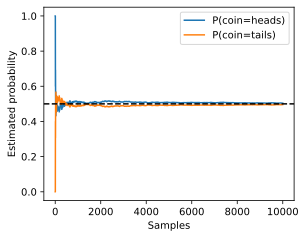

In [7]:
counts = Multinomial(1, fair_probs).sample((10000,))
cum_counts = counts.cumsum(dim=0)
estimates = cum_counts / cum_counts.sum(dim=1, keepdims=True)
estimates = estimates.numpy()

d2l.set_figsize((4.5, 3.5))
d2l.plt.plot(estimates[:, 0], label=("P(coin=heads)"))
d2l.plt.plot(estimates[:, 1], label=("P(coin=tails)"))
d2l.plt.axhline(y=0.5, color='black', linestyle='dashed')
d2l.plt.gca().set_xlabel('Samples')
d2l.plt.gca().set_ylabel('Estimated probability')
d2l.plt.legend();

## Questions from these observations: 

First note that as we get more data by conducting more experiments, the curves converge towards the true probability.

1) How quickly does this convergence happen?
2) If we had already tested many coins manufactured at the same plant, how might we incorporate this information? 

# Random Variables: 

When we talk about events like the roll of a die coming up odds or the first coin toss coming up heads, we are invoking the idea of a _random variable_. 

__Random Variable__: (formally) are mapping from an underlying sample space to a set of (possibly many) values. Every value taken by a random variable corresponds to a subset of the underlying sample space. 

When we use __P(X)__ to refer to the distribution of __X__, we mean the function that tells us the probability that X takes any given values. 

When working with multiple random variables, we can construct events corresponding to every combination of values that the variables can jointly take. The joint probability assigned to the even where random variables _A_ and _B_ take values _a_ and _b_, respectively, is denoted __P(A=a, B=b)__, where the comma indicates "and". 

When reasoning about __conditional probability__ we can think of it as restriction attention only to the subsest of the sample space associated with _A = a_ and then renormalizing so that all probabilities sum to 1.                                       

## Expectations

Often, making decisions requires not just looking at the probabilities assigned to individual events but composing them together into useful aggregates that can provide us with guidance. For example, when random variables take continuous scalar values, we often care about knowing what value to expect on average. This quantity is formally called an expectation. If we are making investments, the first quantity of interest might be the return we can expect, averaging over all the possible outcomes (and weighting by the appropriate probabilities). 

__Expectation is the average of the random variable__.

For financial decisions, we might also want to measure how risky an investment is. Here, we care not just about the expected value but how much the actual values tend to vary relative to this value. Note that we cannot just take the expectation of the difference between the actual and expected values. That is because the expectation of a difference is the difference of the expectations, and thus equal to zero,

The __variance__  of a random variable is calculated by looking at the expected value of the squared deviations. __The square root of the variance is a nother useful quantity called _standard deviation__

# Maximum Likelihood

It is one of the most commonly encountered way of thinking in machine learning. 

__MLE__: is the concept that when working with a probabilistic model with _unknown_ parameters, the parameters which make the data have the _highest probability_ are the most likely ones. 


### The maximum Likelihood Principle


